# <center>Structural Analysis and Visualization of Networks</center>

## <center>Home Assignment #4: Community Detection Algorithms

### <center>Student: *Ishimtsev Vladislav*</center>

#### Preprocessing

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline

### Task 1* (For those who have not done that during the seminar)

On this seminar your are asked to implement simple community detection algorightm. It is called [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

Implement Markor Clustering Algorithm

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usualy $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Prunning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$
<br\>
<br\>

As a result you should get a cluster matrix s.t. elements of the cluster correspont to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.hse.ru/data/2016/03/15/1127695811/network1.mat), [2](https://www.hse.ru/data/2016/03/15/1127699956/network2.mat) and [3](https://www.hse.ru/data/2016/03/15/1127703057/network3.mat).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

<hr />


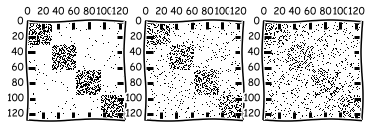

In [2]:
data = [ scipy.io.loadmat('network1.mat'), scipy.io.loadmat('network2.mat'), scipy.io.loadmat('network3.mat')]
A = []
comm = []

for i in range(3):
    A.append(data[i]['A'].astype('float'))
    comm.append(data[i]['Comm'])
    
    plt.subplot(131+i)
    plt.spy(A[i])

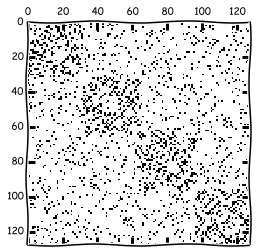

In [3]:
plt.spy(A[i])

Adjacency matrix of network 2 looks noisier that matrix of network 1 and adjacency matrix of network 3 looks noisier that matrix of network 2. Verify that set of clusters (Comm) of all networks are the same.

In [4]:
sim = True
for x in comm:
    for y in comm:
        if (np.linalg.norm(comm[0] - comm[1]) > 0):
            sim = False
print ('different ' if not sim else 'similar ') + 'clusters'

similar clusters


Now let's compute clustering accuracy for Markov Cluster Algorithm. 

In [5]:
comm = comm[0]
# Find cluster matrix and return accuracy of detection
def m_MCL(A, tol=1e-2, p=2, alpha=2, spy=False):
    res_comm = np.empty_like(comm)
    cluster = 1
    
    mcl = MCL(A, tol,p,alpha)
    for x in mcl:
        if np.linalg.norm(x) > 0:
            res_comm[np.where(x>0)] = cluster
            cluster += 1
    acc = 0. if cluster == 1 else 1 - 1.0*len(np.where(res_comm != comm)[0])/comm.shape[0]
    if spy: 
        plt.spy(mcl)
    return acc
    
def MCL(A, tol, p, alpha):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    while(True):
        step += 1
        # Expancion step:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        # Renormalize
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        
        # Prunning
        M1[M1<=tol] = 0        
        M1[np.isnan(M1)] = 0
        if np.linalg.norm(M - M1) == 0:
            #print 'Steps: ', step,
            return M1
        else:
            M = M1.copy()

In [6]:
for i in range(3):
    print 'Network',i+1,':\t', m_MCL(A[i])

Network 1 :	1.0
Network 2 :	0.0078125
Network 3 :	0.0078125


As we can see, MCL can clustering network 1 with 100% accuracy with custom parameters ($alpha=2, p=2$). Now let's tune parameters to get maximum accuracy in network 2 and 3.

In [7]:
alpha = np.linspace(2,21,20)
pp = range(2,21)
tol = np.logspace(-10,-1,10)
tune = np.empty((2,len(alpha),len(pp),len(tol)))

t=0
for i in range(1,3):
    for a in range(len(alpha)):
        for p in range(len(pp)):
            for t in range(len(tol)):
                tune[i-1,a,p,t] = m_MCL(A[i], tol=tol[t], p=pp[p], alpha=alpha[a])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in less_equal


Max accuracy for network 1 is 1.0 with:
	alpha = 2.0
	p = 3
	tol = 0.01
Max accuracy for network 2 is 0.4765625 with:
	alpha = 4.0
	p = 4
	tol = 0.01


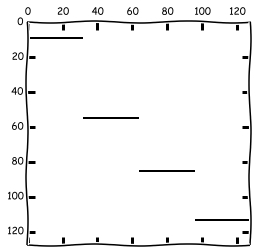

In [8]:
maxArg = [ np.argwhere(tune[0] == np.max(tune[0]))[0], np.argwhere(tune[1] == np.max(tune[1]))[0]]
for i in range(2):
    print 'Max accuracy for network',i+1,'is', np.max(tune[i]), 'with:'
    print '\talpha =', alpha[maxArg[i][0]]
    print '\tp =', pp[maxArg[i][1]]
    print '\ttol =', tol[maxArg[i][2]]
_=m_MCL(A[1], alpha=alpha[maxArg[0][0]], p=pp[maxArg[0][1]], tol=tol[maxArg[0][2]], spy=True)

We get 100% accuracy for the second network. Now let's tune for the third.

Max accuracy for network 2 is 0.5703125 with:
	alpha = 4.76315789474
	p = 4
	tol = 0.0088586679041


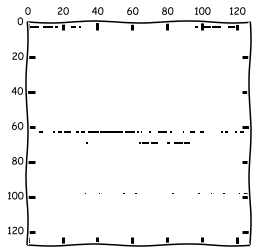

In [9]:
alpha = np.linspace(4.5,5,20)
pp = [4]
tol = np.logspace(-3,-2,20)
tune = np.empty((len(alpha),len(pp),len(tol)))

for a in range(len(alpha)):
    for p in range(len(pp)):
        for t in range(len(tol)):
            tune[a,p,t] = m_MCL(A[2], tol=tol[t], p=pp[p], alpha=alpha[a])
maxArg = np.argwhere(tune == np.max(tune))[0]
print 'Max accuracy for network 2 is', np.max(tune), 'with:'
print '\talpha =', alpha[maxArg[0]]
print '\tp =', pp[maxArg[1]]
print '\ttol =', tol[maxArg[2]]
_=m_MCL(A[2], alpha=alpha[maxArg[0]], p=pp[maxArg[1]], tol=tol[maxArg[2]], spy=True)

For the third network we get only 57%. 

In general, the algorithm proved to be a good, but initialization of parameters is not trivial.

### Task 2

Load [Yahoo Music network](https://www.hse.ru/data/2016/03/15/1127704844/music_data.mat). Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

* Implement *multilevel spectral recursive partitioning* algorithm that was described during the lecture
* Visualize community structure of the network and output some of the dense clusters (with interpretation, if you can)

You can load .mat files with the following commands:

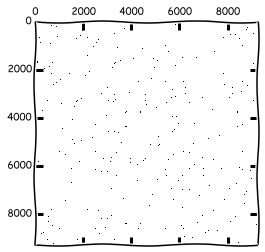

In [10]:
data = scipy.io.loadmat('music_data.mat')['A'].astype('float')
data[data!=0]=1
G = nx.from_scipy_sparse_matrix(data)
plt.spy(data.todense())

Implementation of multilevel spectral recursive partitioning algorithm.

In [11]:
stop = 20
# 2-partition split, a: sparse matrix
def MSPA(a): 
    aa = a.astype('float')
    d = scipy.sparse.csr_matrix(np.diagflat(aa.sum(0)))
    v = scipy.sparse.linalg.eigsh(d - aa,k=2,M=d,which='SM')[1][:,1]
    return np.where(v>0)[0],np.where(v<0)[0]
    
def recursive_MSPA(g, ind=None):
    if ind is None:
        ind = np.arange(g.shape[0])
    g1,g2 = MSPA(g)
    res = recursive_MSPA(g[g1][:,g1],ind[g1]) if len(g1) > stop else ind[g1]  
    return np.concatenate((res, recursive_MSPA(g[g2][:,g2],ind[g2]) if len(g2) > stop else ind[g2]))

Now we need to reorder current adjacency matrix.

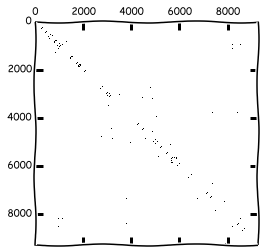

In [12]:
result = recursive_MSPA(data)
plt.spy(nx.adjacency_matrix(G,result).todense())